# **Homework 12 - Adversarial Attack**


## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [1]:
# set up environment
!pip install pytorchcv

# download
!gdown --id '1HQRkshrkTfXufzDeeGov_y6vii4Yd52N' -O data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 27.5 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HQRkshrkTfXufzDeeGov_y6vii4Yd52N
To: /content/data.zip
100% 572k/572k [00:00<00:00, 6.73MB/s]
Archive:  ./data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/cat/
  inflating: __MACOSX/data/._cat     
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/dog/
  inflating: __MACOSX/data/._dog     
   creating: data/truck/
  inflating: __MACOSX/data/._truck   
   creating: data/bird/
  inflating: __MACOSX/data/._bird    
   creating: data/airplane/
  inflating: __MACOSX/data/._airplane

## Global Settings

* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [2]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std
# TODO: iterative fgsm attack
# alpha (step size) can be decided by yourself
alpha = 0.8/255/std

root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [3]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [4]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [5]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    return x_adv

# TODO: perform iterative fgsm attack
# set alpha as the step size in Global Settings section
# alpha and num_iter can be decided by yourself
#def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    # initialize x_adv as original benign image x
    # write a loop of num_iter to represent the iterative times
    # for each loop
        # call fgsm with (epsilon = alpha) to obtain new x_adv
        # clip new x_adv back to [x-epsilon, x+epsilon]
    # return x_adv
    #pass

def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    x_adv = x.detach().clone()
    for _ in range(num_iter):
        x_adv.requires_grad = True
        loss = loss_fn(model(x_adv), y)
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.detach().sign()
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
        x_adv = torch.clamp(x_adv, 0, 1)
        x_adv = x_adv.detach()
    return x_adv

## Utils -- Attack

* Recall
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
    * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
    * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
    * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
    * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [6]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))


In [12]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch.nn as nn

model_names = [
    'resnet110_cifar10',
    'wrn40_8_cifar10',
    'preresnet110_cifar10',
    'diapreresnet110_cifar10',
    'densenet40_k24_bc_cifar10',
    'densenet100_k12_cifar10',
    'ror3_110_cifar10',
    'rir_cifar10',
    'sepreresnet56_cifar10'
]

models = []
for name in model_names:
    model = ptcv_get_model(name, pretrained=True).to(device)
    models.append(model)


# Loss function
loss_fn = nn.CrossEntropyLoss()

# Evaluate ensemble on benign images
benign_acc, benign_loss = epoch_ensemble(models, adv_loader, loss_fn)
print(f'Ensemble benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

# Function to predict using ensemble
def ensemble_predict(models, x):
    outputs = [model(x) for model in models]
    # Average the logits
    avg_output = sum(outputs) / len(models)
    return avg_output

# Update evaluation function to use ensemble
def epoch_ensemble(models, loader, loss_fn):
    for model in models:
        model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        # Get ensemble predictions
        yp = ensemble_predict(models, x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# Update adversarial attack to support ensemble
def fgsm_ensemble(models, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True
    # Compute loss using ensemble predictions
    loss = loss_fn(ensemble_predict(models, x_adv), y)
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    return x_adv

def ifgsm(models, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=50):
    x_adv = x.detach().clone()
    for _ in range(num_iter):
        x_adv.requires_grad = True
        loss = 0
        for model in models:
            loss += loss_fn(model(x_adv), y)  # Aggregate losses from ensemble
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.detach().sign()
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
        x_adv = torch.clamp(x_adv, 0, 1)
        x_adv = x_adv.detach()
    return x_adv
epsilon = 16 / 255 / std  # Increase the perturbation limit
alpha = 2 / 255 / std  # Increase step size


# Generate adversarial examples for an ensemble
def gen_adv_examples_ensemble(models, loader, attack, loss_fn):
    for model in models:
        model.eval()  # Set all models to evaluation mode

    adv_names = []
    total_acc, total_loss = 0.0, 0.0
    adv_examples = None

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)

        # Perform attack using ensemble
        x_adv = attack(models, x, y, loss_fn)
        yp = torch.zeros(x.shape[0], 10).to(device)  # Assuming 10 classes

        # Aggregate predictions from ensemble
        for model in models:
            yp += model(x_adv)

        loss = loss_fn(yp, y)
        total_acc += (yp.argmax(dim=1) == y).sum().item()
        total_loss += loss.item() * x.shape[0]

        # Store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1)  # To 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255)  # To 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round()  # Round to integers
        adv_ex = adv_ex.transpose((0, 2, 3, 1))  # Transpose (bs, C, H, W) to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]

    return adv_examples, total_acc / len(loader.dataset), total_loss / len(loader.dataset)

# Function to create directories and save adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if not os.path.exists(adv_dir):
        os.makedirs(adv_dir, exist_ok=True)  # Create the adversarial directory if it doesn't exist
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8))  # Convert to unsigned int for saving
        save_path = os.path.join(adv_dir, name)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create subdirectories if needed
        im.save(save_path)


# Evaluate ensemble on benign images
benign_acc, benign_loss = epoch_ensemble(models, adv_loader, loss_fn)
print(f'Ensemble benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

# Evaluate ensemble on adversarial examples
# Evaluate ensemble on adversarial examples
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples_ensemble(models, adv_loader, ifgsm, loss_fn)
print(f'Ensemble ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)


Ensemble benign_acc = 0.96000, benign_loss = 0.12821
Ensemble benign_acc = 0.96000, benign_loss = 0.12821
Ensemble ifgsm_acc = 0.00500, ifgsm_loss = 94.28587


In [9]:
'''def mifgsm(models, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=50, decay=1.0):
    x_adv = x.detach().clone()
    grad = torch.zeros_like(x_adv)
    for _ in range(num_iter):
        x_adv.requires_grad = True
        loss = 0
        for model in models:
            loss += loss_fn(model(x_adv), y)
        loss.backward()
        grad = decay * grad + x_adv.grad / x_adv.grad.norm(p=1)
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
        x_adv = torch.clamp(x_adv, 0, 1)
        x_adv = x_adv.detach()
    return x_adv
    '''


In [10]:
'''adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples_ensemble(models, adv_loader, mifgsm, loss_fn)
print(f'Ensemble ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')
'''

NameError: name 'gen_adv_examples_ensemble' is not defined

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [ ]:
'''from pytorchcv.model_provider import get_model as ptcv_get_model

model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')
'''

## FGSM

In [ ]:
'''adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)
'''

## I-FGSM

In [ ]:
'''
#TODO: iterative fgsm attack
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)
'''

## Compress the images

In [13]:
'''%cd fgsm
!tar zcvf ../fgsm.tgz *
%cd ..
'''
%cd ifgsm
!tar zcvf ../ifgsm.tgz *
%cd ..

/content/ifgsm
airplane/
airplane/airplane3.png
airplane/airplane16.png
airplane/airplane6.png
airplane/airplane4.png
airplane/airplane2.png
airplane/airplane19.png
airplane/airplane14.png
airplane/airplane12.png
airplane/airplane15.png
airplane/airplane8.png
airplane/airplane9.png
airplane/airplane11.png
airplane/airplane20.png
airplane/airplane17.png
airplane/airplane13.png
airplane/airplane7.png
airplane/airplane1.png
airplane/airplane18.png
airplane/airplane5.png
airplane/airplane10.png
automobile/
automobile/automobile19.png
automobile/automobile11.png
automobile/automobile5.png
automobile/automobile14.png
automobile/automobile8.png
automobile/automobile3.png
automobile/automobile15.png
automobile/automobile20.png
automobile/automobile2.png
automobile/automobile7.png
automobile/automobile6.png
automobile/automobile1.png
automobile/automobile9.png
automobile/automobile17.png
automobile/automobile13.png
automobile/automobile12.png
automobile/automobile4.png
automobile/automobile16.p

## Visualization

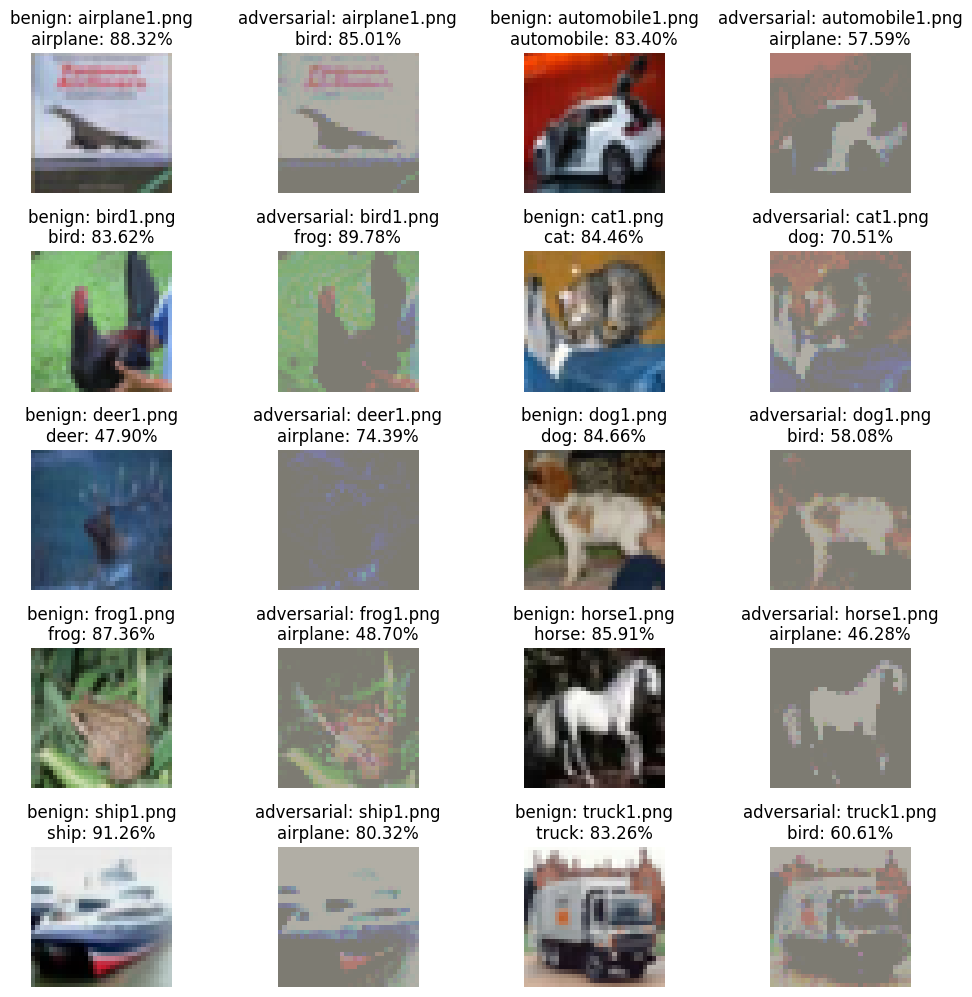

In [14]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./ifgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()